In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchmetrics.functional import dice
import numpy as np
import glob
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class config:
    BASE_PATH = "/kaggle/input/"
    TRAIN_IMG_PATH = BASE_PATH + "train_images/train_images"
    TRAIN_MASK_PATH = BASE_PATH + "train_masks/train_masks"
    TEST_IMG_PATH = BASE_PATH + "test_images/test_images"

# 1. Dataloaders:

In [4]:
# Dataloader :

HEIGHT = 512
WIDTH = 512
BATCH_SIZE = 4

# Create a custom Dataset class
class tensorDataset(Dataset):
    """
    Custom Dataset for loading UAV images and their corresponding masks.
    """
    def __init__(self, image_paths: list, mask_paths: list, train: bool):
        """
        Constructor for the tensorDataset class.

        Parameters:
            image_paths: List of paths to the image files.
            mask_paths: List of paths to the mask files.
            train: Boolean indicating if the dataset is for training or validation.
        """

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.train = train
        
        self.transform_img = transforms.Compose([
            transforms.Resize([HEIGHT,WIDTH]),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize([HEIGHT,WIDTH], interpolation = transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset.

        Parameters:
            index: Index of the item to fetch.

        Returns:
            img: Transformed image tensor.
            mask: Transformed mask tensor.
        """
        
        # Select a specific image's path
        img_path  = self.image_paths[index]
        mask_path = self.mask_paths[index]
        
        # Load the image
        img = Image.open(img_path)
        mask = Image.open(mask_path)
    
        # Apply transformations
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        
        # Scale the mask from 0-1 range to 0-255 range
        mask = mask * 255  
        
        # Reshape mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W) not (B, 1, H, W)
        mask = mask.squeeze(0)
        
        return img, mask

    def __len__(self):
        """
        Get the total number of items in the dataset.

        Returns:
            Total number of images/masks in the dataset.
        """
        return len(self.image_paths)

In [6]:
# Very simple train/test split
train_ratio = 0.7
train_set_last_idx = int(len(glob.glob(config.TRAIN_IMG_PATH + "/*")) * train_ratio)

train_img_paths  = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))[:train_set_last_idx]
train_mask_paths = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))[:train_set_last_idx]
val_img_paths    = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))[train_set_last_idx:]
val_mask_paths   = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))[train_set_last_idx:]

# Create datasets
train_dataset = tensorDataset(train_img_paths, train_mask_paths,train=True)
val_dataset   = tensorDataset(val_img_paths, val_mask_paths, train=False)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 2. Model definition:

## 2.1. Start with a basic model with U-Net like arch

In [8]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, forward_expansion: int,  out_channels: int, expand: bool):
        super(BasicBlock, self).__init__()
        """
        A very simple convlution block. Reduces or expands the size of the image by a factor of 2.
        When using batchnorm, you can set bias=False to preceding convolution.
        """
        self.conv1 = nn.Conv2d(in_channels, forward_expansion, 3, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(forward_expansion)
        self.conv2 = nn.Conv2d(forward_expansion, out_channels, 3, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if expand:
            self.scaling = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        else:
            self.scaling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.scaling(x)
        return x

    
class SampleModel(nn.Module):
    """
    Sample model that leverages the BasicBlock for both downsampling and upsampling.
    The model follows a U-Net like architecture.
    """
    def __init__(self, in_channels=3, out_channels=25):
        super(SampleModel, self).__init__()
        
        # Create downsizing pass
        self.down = nn.ModuleList()
        self.down.append(BasicBlock(3, 256, 256, expand=False))
        self.down.append(BasicBlock(256, 512, 512, expand=False))
        self.down.append(BasicBlock(512, 512, 1024, expand=False))
        
        # Create bottleneck
        self.bottleneck = nn.Conv2d(1024, 1024, 3, stride=1, padding='same')
        
        # Create upsizing pass
        self.up = nn.ModuleList()
        self.up.append(BasicBlock(1024, 512, 512, expand=True))
        self.up.append(BasicBlock(512, 512, 256, expand=True))
        self.up.append(BasicBlock(256, 256, out_channels, expand=True))
        
    def forward(self, x):
        for block in self.down:
            x = block(x)
        x = self.bottleneck(x)
        for block in self.up:
            x = block(x)
        return x

## 2.2. Use a pre-trained Unet-ResNet model (U-Net with ResNet50 as backbone)

In [9]:
# Try with Pytorch UNET-RESNET
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    Middle layer of the U-Net which consists of ConvBlocks.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    """
    U-Net architecture with ResNet-50 encoder.
    """
    
    DEPTH = 6

    def __init__(self, n_classes=25):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# 3. Train the model:

In [11]:
# ======================================
# Utility Classes to save the best model
# ======================================

class SaveBestModel:
    """Class to save the best model during training based on validation accuracy."""
    def __init__(self, best_valid_loss=float('inf'),best_val_acc=float(0)):
        self.best_valid_loss = best_valid_loss
        self.best_val_acc = best_val_acc

    def __call__(self, current_val_acc,epoch, model, optimizer, criterion):
        if current_val_acc > self.best_val_acc:
            self.best_val_acc = current_val_acc
            print(f"\nBest validation accuracy: {self.best_val_acc}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')
            
save_best_model = SaveBestModel()

In [12]:
# ===================================
# Utility Function to train the model
# ===================================

def train(model, epochs, optimizer, criterion):
    """Function to train and validate the model.

    Args:
        model: Model to train.
        epochs: Number od epochs to train the model.
        optimizer: Optimizer choosen for training.
        criterion: Criterion choosen for training.
    """
    
    for epoch in range(epochs):
        
        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []
        val_Dice = []
      
        ###### Train model ######
        model.train()
        for i, batch in enumerate(train_dataloader):
            # Extract images and masks
            img_batch, mask_batch = batch  # img [B,3,H,W], mask[B,H,W]
            img_batch, mask_batch = img_batch.to(device), mask_batch.long().to(device)
            
            # Optimize network
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 25, H, W]
            loss = criterion(output, mask_batch)
            loss.backward()
            optimizer.step()
          
            # Save batch results
            train_losses.append(loss.item())
            preds = torch.argmax(output, dim=1)
            acc = torch.sum(preds == mask_batch).item() / (mask_batch.shape[0] * mask_batch.shape[1] * mask_batch.shape[2])
            # we divide by (batch_size * height * width) to get average accuracy per pixel
            train_accuracy.append(acc)
            
        ###### Validate model ######
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_dataloader):
                #Extract data, labels
                img_batch, mask_batch = batch  # img [B,3,H,W], mask[B,H,W]
                img_batch, mask_batch = img_batch.to(device), mask_batch.long().to(device)

                #Validate model
                output = model(img_batch)
                loss = criterion(output, mask_batch)

                # Save batch results
                val_losses.append(loss.item())
                preds = torch.argmax(output, dim=1)
                dice_score = dice(preds, mask_batch).item()
                acc = torch.sum(preds == mask_batch).item() / (mask_batch.shape[0] * mask_batch.shape[1] * mask_batch.shape[2])
                val_Dice.append(dice_score)
                val_accuracy.append(acc)
            
            
        val_loss_mean = np.mean(val_losses)    
        val_Dice_mean = np.mean(val_Dice)
        
        ##### Print epoch results ######
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, accuracy: {np.mean(train_accuracy):.3f}')        
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, accuracy: {np.mean(val_accuracy):.3f}, dice: {val_Dice_mean:.3f}')
        print('-' * 70)
        save_best_model(val_Dice_mean, epoch, model, optimizer, criterion)

In [13]:
# ======================================
# Model Initialization and Configuration
# ======================================

device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 30
lr = 0.0001
model = UNetWithResnet50Encoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [16]:
train(model, epochs, optimizer, criterion)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TRAIN       Epoch: 0 | Epoch metrics | loss: 2.4365, accuracy: 0.471
VALIDATION  Epoch: 0 | Epoch metrics | loss: 2.1204, accuracy: 0.569, dice: 0.569
----------------------------------------------------------------------

Best validation accuracy: 0.5694082736968994

Saving best model for epoch: 0

TRAIN       Epoch: 1 | Epoch metrics | loss: 1.8580, accuracy: 0.660
VALIDATION  Epoch: 1 | Epoch metrics | loss: 1.8362, accuracy: 0.626, dice: 0.626
----------------------------------------------------------------------

Best validation accuracy: 0.6262375354766846

Saving best model for epoch: 1

TRAIN       Epoch: 2 | Epoch metrics | loss: 1.6642, accuracy: 0.679
VALIDATION  Epoch: 2 | Epoch metrics | loss: 1.7881, accuracy: 0.599, dice: 0.599
----------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 1.6074, accuracy: 0.663
VALIDATION  Epoch: 3 | Epoch metrics | loss: 1.5765, accuracy: 0.658, dice: 0.658
-------------------------

# 4. Error Analysis:

In [17]:
# Loading best model trained checkpoint
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [18]:
# Transfer model from gpu to cpu
model = model.cpu()

In [19]:
def visualise_model_performance(model: nn.Module, idx: int):
    
    # Load image
    img_paths = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))
    mask_paths = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))
    img_path = img_paths[idx]
    mask_path = mask_paths[idx]
    img = Image.open(img_path)
    true_mask = Image.open(mask_path)
    
    # Resize to the same shape as used in training
    img = train_dataset.transform_img(img)
    true_mask = train_dataset.transform_mask(true_mask)
    
    # Model accepts batches of images, not single images so we need to reshape tensors
    # From [C, H, W] to [B, C, H, W]
    img = img.unsqueeze(0)
    
    # Get predictions
    output = model(img)
    preds = torch.argmax(output, dim=1)
    
    # Tranform to numpy and reshape for plotting
    img = img.squeeze().permute(1,2,0).detach().numpy()
    preds = preds.permute(1,2,0).detach().numpy()
    true_mask = true_mask.permute(1,2,0).detach().numpy()
    
    # Plot
    f, axarr = plt.subplots(1,3, figsize=(15,5))
    axarr[0].imshow(img)
    axarr[1].imshow(preds, cmap='tab20')
    axarr[2].imshow(true_mask, cmap='tab20')
    axarr[0].set_title('Image')
    axarr[1].set_title('Model prediction')
    axarr[2].set_title('True mask')
    for ax in axarr:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

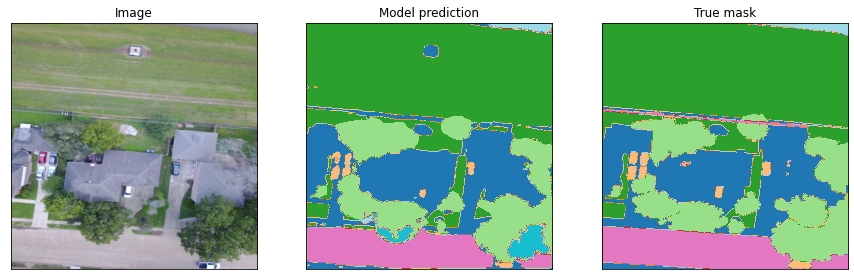

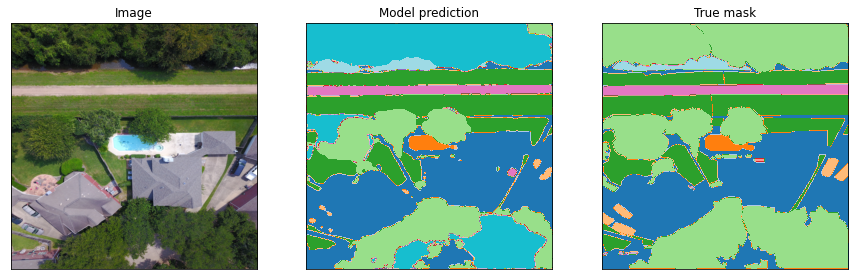

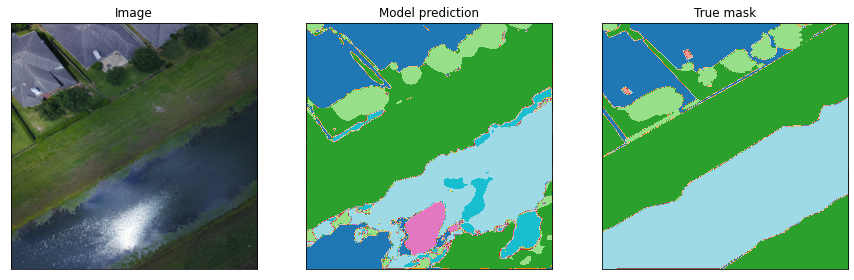

In [20]:
visualise_model_performance(model, 10)
visualise_model_performance(model, 100)
visualise_model_performance(model, 200)

# 5. KAGGLE Chall Submission:

In [21]:
!mkdir /kaggle/working/test_predictions

In [22]:
# Load and transform test images
test_img_link_list = sorted(glob.glob(config.TEST_IMG_PATH + '/*'))
torch_list = [val_dataset.transform_img(Image.open(link)) for link in test_img_link_list]

In [23]:
model.eval()

# calculate output for each image in test set and save the prediction in new folder
for i in tqdm(range(len(torch_list))):
    img_id = test_img_link_list[i].split('/')[-1].split('.')[0]
    img = torch_list[i].unsqueeze(0)
    output = model(img)
    output = torch.argmax(output, dim=1).squeeze(0)
    output = np.uint8(output)
    output = Image.fromarray(output)
    output.save(f"/kaggle/working/test_predictions/{img_id}.png")

100%|██████████| 112/112 [08:49<00:00,  4.72s/it]
